In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
from scipy.stats import f
from prettytable import PrettyTable
import datetime
import os # to save file to a selected directories, which do not need to be created
import scipy.special as ss


class frechet_gen(rv_continuous):
    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))

frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [2]:
q = [0.98, 0.99, 0.995, 0.999, 0.9995]
beta_frechet = 1/2
quant_th = np.zeros(len(q))
for i in range(len(q)):
    quant_th[i] = pow(-log(q[i]), -beta_frechet)

def PWM_GPD(excesses, k, u):
    quant_PWM_GPD = np.zeros(len(q))
    sum1, sum2 = 0, 0
    for i in range(k):
        sum1 += excesses[i]
        sum2 += i * excesses[i]
    mu0 = sum1 / k
    mu1 = sum1 / k - sum2 / k / k
    sigma = 2 * mu0 * mu1 / (mu0 - 2 * mu1)
    gamma = (mu0 - 4 * mu1) / (mu0 - 2 * mu1)
    for i in range(len(q)):
        quant_PWM_GPD[i] = u + sigma / gamma *( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
    return(quant_PWM_GPD)

def MOM_Fisher(excesses, k, u):
    "i use notation: tau0 = EX, tau1 = m12 / m_12, tau2 = m34 / m_34"
    quant_MOM_Fisher = np.zeros(len(q))
    c0 = 1 / k * np.sum(excesses)
    c1 = np.sum([pow(x,1/2) for x in excesses])/np.sum([pow(x,-1/2) for x in excesses])
    c2 = np.sum([pow(x,3/4) for x in excesses])/np.sum([pow(x,-1/4) for x in excesses])

    alpha2_prim = (c2 - c0) / 2/(-c0 -  c1 + 2 * c2)
    alpha1_prim = (c1 * alpha2_prim)/ 2 / (c0 * (alpha2_prim - 1/2) - alpha2_prim * c1)

    alpha1 = alpha1_prim + 1/2
    alpha2 = alpha2_prim + 1/2
    beta = c1 * (alpha2 - 1/2) / (alpha1 - 1/2)

    beta0 = alpha2/alpha1
    for i in range(len(q)):
        quant_MOM_Fisher[i] = u +  f.isf(N / k * (1 - q[i]), 2 * alpha1, 2 * alpha2, loc = 0, scale = beta / beta0)
    return(quant_MOM_Fisher)

def MOM_GPD(excesses, k, u):
    quant_MOM_GPD = np.zeros(len(q))
    c0 = 1 / k * np.sum(excesses)
    c1 = np.sum([pow(x,1/2) for x in excesses]) / np.sum([pow(x,-1/2) for x in excesses])
#     c2 = np.sum([pow(x,3/4) for x in excesses])/np.sum([pow(x,-1/4) for x in excesses])
    alpha2 = (c1 - c0) / (2 * c1 - c0)
    beta = c0 * (alpha2 - 1)
#     alpha2 = alpha2_prim + 1/2
    for i in range(len(q)):
        quant_MOM_GPD = u + beta * ( pow( N * (1 - q[i]) / k, - 1 / alpha2 ) - 1 )
    return(quant_MOM_GPD)

In [3]:
def k_greatest_values_matrices(a,k):
    """returns k greatest elements from the list a and k - 1 value starting from which we consider greater values as extremes"""
    # we prepare the matrix for the excesses, the last value of 1 could be substituted by any value within the range
    mat = np.zeros( len(a[-1 - k + 1 : , 1] ) ) 
    # we prepare the vector in which we will return u values for each dataset in column of a
    u = np.zeros(len(r[0 , : ] )) 
    for i in range(len(a[0,:])): 
        # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
        u[i] = a[-1 - k, i] 
        # u is a list of values s.t. bigger values are considered as excesses, for each set of data, i.e. for each column we save an u value
        mat = np.column_stack( (mat,a[ -1 - k + 1 : , i]) ) 
    # in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [4]:
n = 20 # number of sampled datasets over which we average the quantiles
how_many_different_thresholds =35
min_thresholds = 100
max_thresholds = 500
N = 1000

r = frechet.rvs(beta_frechet, size=N) 
for i in range(n):
    r = np.column_stack( (r, frechet.rvs(beta_frechet, size=N) ) ) 

# we need to sort in increasing order sampled data
for i in range(len(r[0,:])):
    r[:,i] = np.sort(r[:,i], axis=None)

In [5]:
# astype function converts the values in the array to integers
jump_excesses = np.linspace(min_thresholds, max_thresholds, how_many_different_thresholds).astype(int) 

number_of_GPD_params = 2
number_of_Fisher_params = 3

now = datetime.datetime.now() # we take it globally to save all the tables and plots in one directory

# probability_weighted_moments_GPD = np.zeros(len(q))
concatenated_PWM_GPD = np.zeros(len(q))
concatenated_MOM_Fisher = np.zeros(len(q))
concatenated_MOM_GPD = np.zeros(len(q))

In [6]:
for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    data_frechet, u = k_greatest_values_matrices(r,k) 
    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)
    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 
    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
    
    averaged_PWM_GPD = np.zeros(len(q))
    averaged_MOM_Fisher = np.zeros(len(q))
    averaged_MOM_GPD = np.zeros(len(q)) 
    for i in range(n): 
        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] 
        averaged_PWM_GPD += 1 / n * PWM_GPD(excesses_array, k, u[i])
        averaged_MOM_Fisher += 1/n * MOM_Fisher(excesses_array, k, u[i])
        averaged_MOM_GPD += 1/n *MOM_GPD(excesses_array, k, u[i])

#     print(" MOM Fisher ", averaged_MOM_Fisher)    
#     print(" pwm ", averaged_PWM_GPD)    
    concatenated_MOM_GPD = np.column_stack((concatenated_PWM_GPD,averaged_MOM_GPD))
    concatenated_MOM_Fisher = np.column_stack((concatenated_MOM_Fisher,averaged_MOM_Fisher))
    concatenated_PWM_GPD= np.column_stack((concatenated_PWM_GPD, averaged_PWM_GPD))    

In [7]:
# we delete first column which was created as zeros
# we need those to plot quantiles on one plot and to compare them
concatenated_MOM_GPD = np.delete(concatenated_MOM_GPD, 0,1)
concatenated_PWM_GPD = np.delete(concatenated_PWM_GPD, 0,1)
concatenated_MOM_Fisher = np.delete(concatenated_MOM_Fisher, 0,1)
# super_concatenated_probability_weighted_moments_GPD = np.delete(super_concatenated_probability_weighted_moments_GPD, 0, 1)

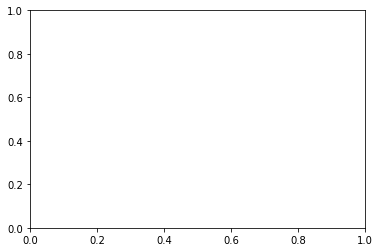

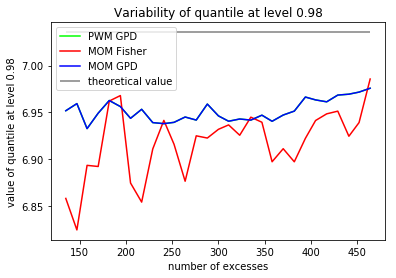

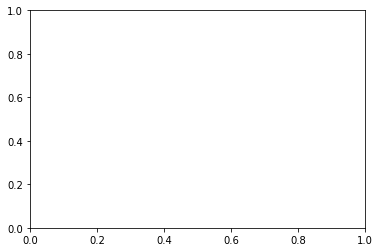

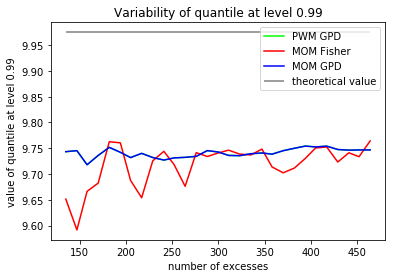

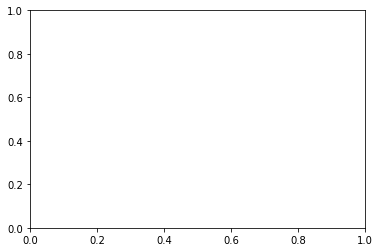

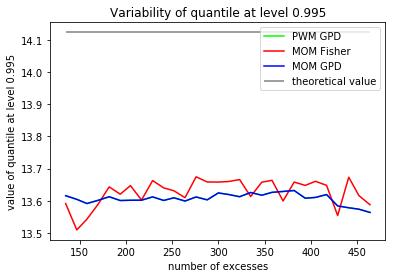

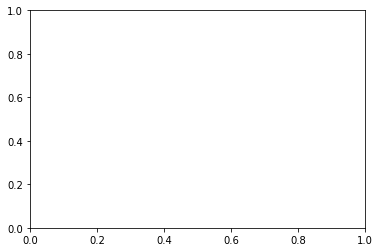

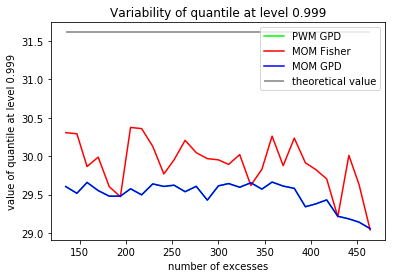

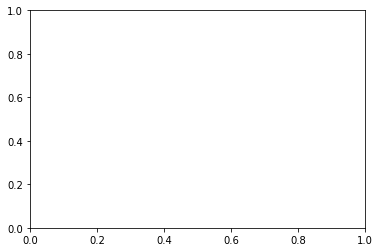

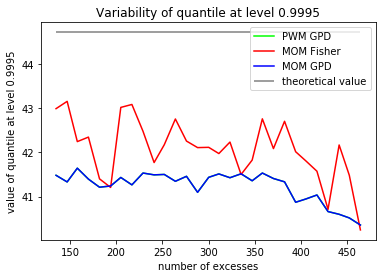

In [18]:
for i in range(len(q)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
    name = " quant_level_" + str(q[i])
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    sample_file_name = name + '.pdf'
    fig = plt.figure()
    if not os.path.isdir(results_dir): # if the directory does not exist we create it 
        os.makedirs(results_dir)
    ax = fig.add_subplot(111)
    fig.savefig(results_dir + sample_file_name ) 
    
    plt.hlines(y=quant_th[i], 
               xmin=min(jump_excesses[3:]), 
               xmax=max(jump_excesses[0:how_many_different_thresholds-3]), 
               color='gray', 
               zorder=1, 
               label='theoretical value')
    plt.plot(jump_excesses[3:how_many_different_thresholds-3], concatenated_PWM_GPD[i,3:how_many_different_thresholds-3], 'lime', label='PWM GPD')
    plt.plot(jump_excesses[3:how_many_different_thresholds-3], concatenated_MOM_Fisher[i,3:how_many_different_thresholds-3], 'red', label='MOM Fisher')
    plt.plot(jump_excesses[3:how_many_different_thresholds-3], concatenated_MOM_GPD[i,3:how_many_different_thresholds-3], 'blue', label='MOM GPD')

    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(q[i]))
    plt.title('Variability of quantile at level ' + str(q[i])  )
    plt.legend()#     plt.savefig(results_dir + sample_file_name)
    
    plt.savefig(results_dir + sample_file_name)

plt.show()

In [9]:
# for i in range(len(q)):
#     compare_quantiles(jump_excesses,
#                   concatenated_averaged_quant_GPD, 
#                   concatenated_averaged_bayesian_quant_GPD, 
#                   concatenated_averaged_quant_Fisher,
#                   concatenated_averaged_bayesian_quant_Fisher,
#                   concatenated_median_quant_BGPD,
#                   concatenated_median_quant_BFisher, 
#                   concatenated_averaged_probability_weighted_moments_GPD,
#                   quant_th,
#                   i,now)

In [10]:
# plots comparing Fisher and GPD

# x = np.arange(0.05,0.5,0.002)
# def GPD_pdf(x, alpha, beta):
#     return alpha / beta * pow(1 + x / beta , - asarray(alpha)  - 1 )
# def Fisher_pdf(x, alpha1, alpha2, beta):
#     return 1 / beta / ss.beta(alpha1, alpha2) * pow(x / beta, asarray(alpha1) - 1) / pow(1 + x / beta, asarray(alpha1 + alpha2))


# alpha1 = np.linspace(0.01, 2, 16)
# # alpha1 = [0.25, 0.4, 0.55, 0.7, 0.85, 1.15, 1.3, 1.45, 1.6]
# #
# alpha2 = [1, 5, 10]
# beta = [1/2, 1, 2]

# for k in range(len(beta)):
#     for j in range(len(alpha2)):
#         dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
#         name = " comp_GPD_Fisher_" + str(alpha2[j]) + "_" + str(beta[k])
#         script_dir = os.path.dirname('__file__')
#         results_dir = os.path.join(script_dir, dir_name + '/')
#         sample_file_name = name + '.pdf'
#         fig = plt.figure()
#         if not os.path.isdir(results_dir): # if the directory does not exist we create it 
#             os.makedirs(results_dir)
#         ax = fig.add_subplot(111)
#         fig.savefig(results_dir + sample_file_name )
#         #------------
#         plt.plot(x, Fisher_pdf(x, 1, alpha2[j], beta[k]), linewidth=3.0, color='red', label='Fisher(1,'+ str(alpha2[j]) + ',' + str(beta[k]) + ')')
#         for i in range(len(alpha1)):
#             plt.plot(x, Fisher_pdf(x, alpha1[i], alpha2[j], beta[k]), 'gray')
            
#         plt.xlabel('x')
#         plt.ylabel('f(x)')
#         title = "GPD(" + str(alpha2[j]) + ',' + str(beta[k]) + ') vs. Fisher(x,'+ str(alpha2[j]) + ',' + str(beta[k]) + ')' 
#         # 'GPD(a,b) vs. Fisher(x,a,b)'
#         plt.title(title )
#         plt.savefig(results_dir + sample_file_name)
#         plt.legend()
#         plt.show()



In [11]:
# list1 = [super_concatenated_probability_weighted_moments_GPD]
#         super_concatenated_quant_GPD,
#         super_concatenated_bayesian_quant_GPD,
#         super_concatenated_quant_Fisher,
#         super_concatenated_bayesian_quant_Fisher,
#         bank_medians_GPD,
#         bank_medians_Fisher ]
# list1_names = ["PWM GPD"]
#         "GPD",
#         "bayes GPD",
#         "Fisher",
#         "bayes Fisher",
#         "median GPD",
#         "median Fisher" ]

# for k in range(len(list1)): # for a given method
#     for j in range(len(q)): # choose a given quantile level
#         for i in range(n): # then choose and plot values obtained for each of the datasets

In [12]:
# for k in range(len(list1_names)):
#     for i in range(len(q)):
#         sd, mn = np.zeros(how_many_different_thresholds),np.zeros(how_many_different_thresholds)
#         for j in range(how_many_different_thresholds):
#             mn[j] = np.mean(list1[k][i])
#             sd[j] = np.sqrt(np.var(list1[k][i]))
#         fig = plt.figure()
        

#         _, ax = plt.subplots()
#         ax.plot(jump_excesses,  mn, color = 'red')
#         ax.plot(jump_excesses,  mn+sd, 'darkgreen')
#         ax.plot(jump_excesses,  mn-sd, 'darkgreen')
#         ax.axhline(quant_th[i], xmin=0, xmax=1,color='gray')
#         ax.fill_between(jump_excesses, mn+sd, mn-sd, color = 'green', alpha = 0.4, label = 'mean +/- sd')
#         title = "mean +/- sd for " + list1_names[k] + " for quantile q = " + str(q[i])
#         ax.set_title(title)
#         ax.set_xlabel("number of thresholds")
#         ax.set_ylabel("value of estimated quantile")
#         ax.legend(loc = 'best')


In [13]:
# plot on the above plots the theoretical values of quantiles quant_th[i]
# plus saving all the plots to put them into ShareLatex

In [14]:
print("mom gpd",concatenated_MOM_GPD)
print("pwm gpd", concatenated_PWM_GPD)
print("diff",concatenated_MOM_GPD -  concatenated_PWM_GPD)

mom gpd [[ 7.00601199  6.98608475  6.97234058  6.95181512  6.95941437  6.93274417
   6.94920249  6.96271535  6.95625173  6.94374688  6.95334176  6.93916435
   6.93804276  6.93944444  6.94512208  6.94186064  6.9589239   6.94632481
   6.94062282  6.94301028  6.94183289  6.94708886  6.94057466  6.94723342
   6.95142554  6.96641466  6.96336843  6.961323    6.96850705  6.96946798
   6.97168876  6.97580172  6.97632791  6.97727652 36.91949004]
 [ 9.80700512  9.78070798  9.76807695  9.74333224  9.74533477  9.71801989
   9.73598504  9.75168851  9.74209422  9.73189516  9.74006974  9.73199901
   9.72707372  9.73125584  9.732353    9.73426081  9.7454023   9.7426036
   9.73606033  9.73557002  9.73934301  9.7408285   9.73853535  9.7452367
   9.74990365  9.75421241  9.75253805  9.75406895  9.74751941  9.74630058
   9.74669387  9.74670687  9.74432013  9.7470307  36.91949004]
 [13.6560092  13.63577089 13.63496803 13.61565363 13.6044142  13.59132421
  13.60125254 13.61246412 13.6006749  13.60153019 13.6